# Memorability Classifier

#### Dataset: VISCHEMA PLUS
#### Dataset image shape: (3x700x700)
#### Dataset label shape: (3x700x700)
#### Dataset label format:
VMS map. It is a 3x700x700 image that is mostly black, the image outputted is a representation of the most memorable locations in the input.

#### Model Plan
I think a U-net would be best here. I will have to learn how to use skip connections.

#### Loss function considerations:
Maybe squared difference between every pixel in the expected output vs the predicted output. This might be computationally expensive.

In [1]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image

#### Dataclass and Dataloaders
I need to create a custom dataclass because the labels are more complex than strings. I have called this VISCHEMA_PLUS. I tried to load all of the images into memory at initialisation but that caused my laptop to run out of memory. Instead I will load an image when it is called by the `__getitem__` method.

In [2]:
class VISCHEMA_PLUS(Dataset):
    def __init__(self, image_dir = 'VISCHEMA_PLUS/images', label_dir = 'VISCHEMA_PLUS/vms', transform = None):
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        
        all_images = os.listdir(image_dir)
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.image_dir}/{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.label_dir}/{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

# I have resized the images to 512x512 as this will make designing the model easier.
image_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.Normalize(0.5,0.5)
])
        
dataset = VISCHEMA_PLUS(transform = image_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(test_dataset)}  Items in Test dataset')

1280 Items in Train dataset
320  Items in Test dataset


#### Test that the images and labels look good

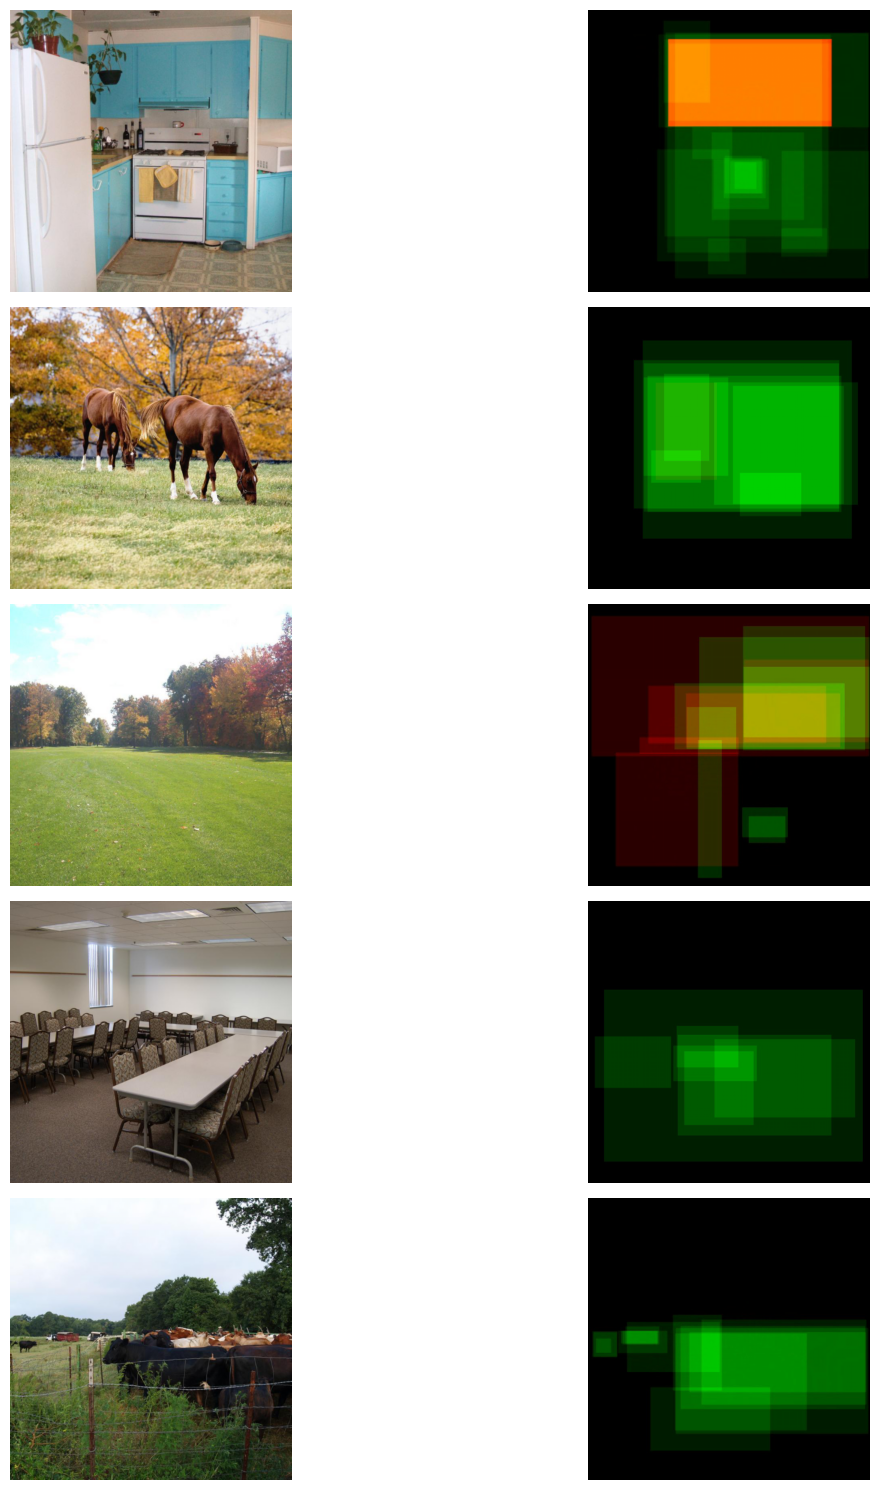

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(15,15))
cols, rows = 1, 5
for i in range(cols * rows):
    figure.add_subplot(rows,cols*2, 2*i+1)
    plt.axis("off")
    plt.imshow((images[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
    figure.add_subplot(rows,cols*2, 2*i+2)
    plt.axis("off")
    plt.imshow((labels[i,:].squeeze().permute(1, 2, 0) +1 )/2 )
plt.tight_layout()
plt.show()

#### Creating Models
There isn't a lot of data so maybe transfer learning would be a better idea but first I want to make my own models so that I can at least track some improvement.

I want to automatically test a range of models and train them all with various hyperparameters. I will create a range of models, a function that returns an instanciated copy of each model in a list, loop over that list along with all of the hyperparameters that I want to tune, and save the results in a `.txt` file.

In [24]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.down_layers = nn.Sequential(
            self.__downBlock(3, 6, 3, 1, 1, 2, 2),   #Output is 6x256x256
            self.__downBlock(6, 12, 3, 1, 1, 2, 2),  #Output is 12x128x128
            self.__downBlock(12, 32, 3, 1, 1, 2, 2), #Output is 32x64x64
            self.__downBlock(32, 128, 3, 1, 1, 4, 4) #Output is 128x16x16
        )

        self.mid_layer = nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,1),
        )

        self.up_layers = nn.Sequential(
            self.__upBlock(256, 128, 4, 1, 1), #Output is 128x16x16
            self.__upBlock(128, 32, 4, 4, 0),  #Output is 32x64x64
            self.__upBlock(32, 12, 4, 2, 1),   #Output is 12x128x128
            self.__upBlock(12, 6, 4, 2, 1),    #Output is 6x256x256
            self.__upBlock(6, 3, 4, 2, 1),     #Output is 3x512x512
        )

    def __downBlock(self, in_channels, out_channels, conv_kernel_size, conv_stride, padding, pool_kernel, pool_stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, conv_kernel_size, conv_stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride),
        )

    def __upBlock(self, in_channels, out_channels, conv_kernel_size, conv_stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                conv_kernel_size, 
                conv_stride, 
                padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        # Input x has dimensions B x 3 x 512 x 512, B is batch size
        x = self.down_layers(x)
        x = self.mid_layer(x)
        x = self.up_layers(x)
        # Output has dimensions B x 3 x 512 x 512
        return x

model = Model1()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in CNN')

images, labels = next(iter(train_loader))
output = model(images)
print(output.shape)

935295 Parameters in CNN
torch.Size([32, 3, 512, 512])
